# [CptS 215 Data Analytics Systems and Algorithms](https://piazza.com/wsu/fall2017/cpts215/home)
[Washington State University](https://wsu.edu)

[Gina Sprint](http://eecs.wsu.edu/~gsprint/)
# L10-2 Decision Trees

Learner objectives for this lesson:
* Understand a decision tree
* Understand entropy
* Implement the id3 tree building algorithm


## Acknowledgments
Content used in this lesson is based upon information in the following sources:
* [Data Science from Scratch](https://www.amazon.com/Data-Science-Scratch-Principles-Python/dp/149190142X/ref=sr_1_1?ie=UTF8&qid=1491521130&sr=8-1&keywords=joel+grus) by Joel Grus
* [Data Mining](https://www.amazon.com/Data-Mining-Practical-Techniques-Management/dp/0123748569/ref=sr_1_2?ie=UTF8&qid=1491521294&sr=8-2&keywords=data+mining+ian) by Ian Witten

## Decision Trees
A decision tree uses a tree to represent a number of possible *decision paths* and an outcome for each path. Decision trees are a popular machine learning model because they are easy to read and interpret, the decision path for unseen data is transparent, and when used in more advanced machine learning algorithms (random forests, ensemble learning, etc.) they form quite powerful predictive models. Decision trees can be trained to predict categorical outcomes (classification trees) or numeric outcomes (regression trees). We are going to focus on *binary* classification trees, trees that predict one of two possible categorical outcomes. For example, predicting "hire" or "no hire" for potential job candidates is an example of a binary classification problem.

Non-leaf nodes (decision nodes) in a decision tree involve testing a particular feature, or attribute, typically against a constant value. Leaf nodes in a decision tree represent a classification, a set of classifications, or a probability distribution over all possible classifications that applies to all instances that reach the leaf.

Let's take a look at an example. Suppose we have built a tree to classify whether a passenger aboard the [Titanic](https://en.wikipedia.org/wiki/RMS_Titanic) survived the shipwreck or not:
<img src="https://upload.wikimedia.org/wikipedia/commons/f/f3/CART_tree_titanic_survivors.png" width="400"/>

(image from [https://upload.wikimedia.org/wikipedia/commons/f/f3/CART_tree_titanic_survivors.png](https://upload.wikimedia.org/wikipedia/commons/f/f3/CART_tree_titanic_survivors.png))

Where "sex" is the gender of the passenger, "age" is the age of the passenger in years (fractional if age is less than one), and "sibsp" is the number of siblings/spouses aboard the vessel.

Let's walk through a few examples of making a prediction for different passengers using this tree. To classify an example passenger as "survived" or "died" the example is routed down the tree according to the values of its attributes tested in successive nodes. When a leaf node is reached the example is classified based on the class assigned to the leaf.

|sex|age|sibsp|prediction|
|-|-|-|-|
|female|30|0|survived|
|male|45|2|died|
|male|8|0|survived|
|male|6|3|died|


## Classification Tree Implementation
To implement a classification tree, we are going to have to decide what questions to ask (and in what order) to partition our dataset into a decision tree structure. To do this, we need to find out which features are the most informative. A feature that clearly divides the examples is a good feature to use in our tree. 

### Entropy
Let's first discuss the notion of *entropy*. Entropy is going to be our measure of how much uncertainty is contained in the data. If all examples in a dataset belong to the same class, then there is no uncertainty about which class these examples belong to and therefore low entropy. If the examples in a dataset are evenly spread across different classes, then there is a high amount of uncertainty and therefore high entropy.

(notation adopted from Joel Grus)

To code up a function to compute the entropy of a data set, we need a mathematical definition of entropy. Let $S$ by a dataset contain examples that each belong to one of a finite number ($n$) of classes $C_{1},...,C_{n}$. If $P_{i}$ is the proportion of data labeled as class $C_{i}$, then entropy $H$ of the dataset $S$ is defined as:

$$H(S) = -p_{1} log_{2} p_{1} - ... - p_{n} log_{2} p_{n}$$

such that $0 log 0 = 0$. Each term $-p_{i} log_{2} p_{i}$ is close to zero when $p_{i}$ is either close to zero or close to one:

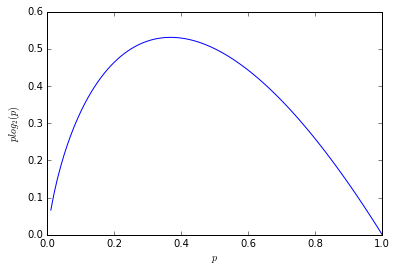

In [70]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

p = np.arange(0.01, 1.01, 0.01)
plogp = -p * np.log2(p)
plt.xlabel("$p$")
plt.ylabel("$p log_{2}(p)$")
plt.plot(p, plogp)

The summation of $H(s)$ will be small when each $p_{i}$ is close to zero or close to one (most examples belong to a single class) and will be large when each $p_{i}$ is close to ~0.5 (the examples are spread across multiple classes). Let's write the code to represent this mathematical behavior.

In [71]:
from collections import Counter

def compute_entropy(class_probabilities):
    '''
    class_probabilities is a list of class probabilities
    '''
    terms = [-pi * np.log2(pi) for pi in class_probabilities if pi] # ignore zero probabilities
    H = np.sum(terms)
    return H

def compute_class_probabilities(instance_labels):
    '''
    instance_labels is a list of each examples' class label
    '''
    num_examples = len(instance_labels)
    counts = list(Counter(instance_labels).values())
    probabilities = np.array(counts) / num_examples
    return probabilities

def compute_subset_entropy(subset):
    '''
    subset is a list of instances as two-item tuples (attributes, label)
    '''
    labels = [label for _, label in subset]
    probabilities = compute_class_probabilities(labels)
    entropy = compute_entropy(probabilities)
    return entropy
    
# all in one class -> low uncertainty -> low entropy
x = np.array([5, 5, 5, 5, 5, 1, 5, 2, 5, 5])
cps = compute_class_probabilities(x)
entropy = compute_entropy(cps)
print(cps, entropy)

# even spread across classes -> high uncertainty -> high entropy
x = np.array([5, 5, 5, 1, 1, 1, 2, 2, 2, 2])
cps = compute_class_probabilities(x)
entropy = compute_entropy(cps)
print(cps, entropy)

[ 0.1  0.1  0.8] 0.921928094887
[ 0.3  0.4  0.3] 1.57095059445


Now, we are ready to apply our measurement of entropy to build our tree. As we construct our tree, we are going to need to figure out what decision to make at our decision nodes. To do this, we are going to partition our data set $S$ into subsets $S_{1},...,S_{m}$ containing proportions $q_{1},...,q_{m}$ of the data. We can then compute the entropy of the partition as the weighted sum of each subset's entropy:

$$H = -q_{1} H(S_{1}) + ... + q_{m} H(S_{m})$$

Ideally, we want a partition to have low entropy if it splits the data into subsets that have low entropy and high entropy if it splits the data insto subsets that are large and have high entropy.

In [72]:
def compute_partition_entropy(subsets):
    '''
    subsets is a list of class label lists
    '''
    num_examples = np.sum([len(s) for s in subsets])
    entropies = [(len(s) / num_examples) * compute_subset_entropy(s) for s in subsets]
    partition_entropy = np.sum(entropies)
    return partition_entropy

### ID3 Algorithm
Next, we need to add our infrastructure to read in the data, build a tree, and make classifications on unseen data. To build a tree, we are going to implement the ID3 algorithm. Starting with the entire dataset and all attributes, we are going to follow the following process to build a tree (from Joel Grus' text):
1. If the data all have the same label, then create a leaf node that predicts that label and then stop.
1. If the list of attributes is empty (i.e. there are no more possible questions to ask), then create a leaf node that predicts the most common classification label and then stop.
1. Otherwise, try partition the data by each of the attributes.
    1. Choose the partition with the lowest partition entropy.
    1. Add a decision node based on the chosen attribute.
    1. Recur on each partitioned subset using the remaining attributes.
    
> This is what's known as a "greedy" algorithm because, at each step, it chooses the most immediately best option. Given a dataset, there may be a more optimal tree with a worse-looking first move. If so, this algorithm won't find it. Nonetheless, it is relatively easy to understand and implement, which makes it a good place to being exploring decision trees.

### Example Dataset
To implement the ID3 algorithm step by step, we will use Joel Grus' example dataset. In this dataset, each instance example is an attribute list describing a job candidate:
* Level of expertise (string)
* Preferred language (string)
* Whether she is active on twitter (boolean)
* Whether she has a PhD (boolean)
* Interviewed well? (boolean)

The classification for this dataset defines whether or not the job candidate interviewed well (True) or not (False).

In [73]:
inputs = [
        ({'level':'Senior','lang':'Java','tweets':'no','phd':'no'},   False),
        ({'level':'Senior','lang':'Java','tweets':'no','phd':'yes'},  False),
        ({'level':'Mid','lang':'Python','tweets':'no','phd':'no'},     True),
        ({'level':'Junior','lang':'Python','tweets':'no','phd':'no'},  True),
        ({'level':'Junior','lang':'R','tweets':'yes','phd':'no'},      True),
        ({'level':'Junior','lang':'R','tweets':'yes','phd':'yes'},    False),
        ({'level':'Mid','lang':'R','tweets':'yes','phd':'yes'},        True),
        ({'level':'Senior','lang':'Python','tweets':'no','phd':'no'}, False),
        ({'level':'Senior','lang':'R','tweets':'yes','phd':'no'},      True),
        ({'level':'Junior','lang':'Python','tweets':'yes','phd':'no'}, True),
        ({'level':'Senior','lang':'Python','tweets':'yes','phd':'yes'},True),
        ({'level':'Mid','lang':'Python','tweets':'no','phd':'yes'},    True),
        ({'level':'Mid','lang':'Java','tweets':'yes','phd':'no'},      True),
        ({'level':'Junior','lang':'Python','tweets':'no','phd':'yes'},False)
    ]

### ID3 Implementation

In [74]:
def partition_by(inputs, attribute):
    '''
    inputs is a list of tuple pairs: (attribute_dict, label)
    attribute is the proposed attribute to partition by
    returns a dictionary of attribute value: input subsets pairs
    '''
    subsets = {}
    for example in inputs:
        attribute_value = example[0][attribute]
        if attribute_value in subsets:
            subsets[attribute_value].append(example)
        else: # add this attribute_value to the dict
            subsets[attribute_value] = [example]
    return subsets

def partition_entropy_by(inputs, attribute):
    '''
    compute the partition
    compute the entropy of the partition
    '''
    subsets = partition_by(inputs, attribute)
    entropies = compute_partition_entropy(subsets.values())
    return entropies

def find_min_entropy_partition(inputs, attributes=None):
    '''
    
    '''
    if attributes is None:
        attributes = list(inputs[0][0].keys())
    partition_entropies = []
    for attribute in attributes:
        partition_entropy = partition_entropy_by(inputs, attribute)
        print(attribute, partition_entropy)
        partition_entropies.append(partition_entropy)
    min_index = np.argmin(partition_entropies)
    return attributes[min_index]
        
attribute = find_min_entropy_partition(inputs)
print(attribute)

phd 0.892158928262
level 0.693536138896
tweets 0.788450457308
lang 0.860131712855
level


We see the entropy values for splitting on each possible attribute. The attribute `level` gives the lowest entropy so this will be our first attribute to split on in our decision tree. Now comes the part of actually building the tree. We are going to follow Joel Grus' implementation and define a *tree* to be one of the following:
* `True` (leaf node): positive classification
* `False` (leaf node): negative classification
* `(attribute, subtree_dict)` (decision node): a tuple that classifies an example by `subtree_dict` using `attribute`

To handle a missing (or unexpected) attribute value, we'll add a `None` key that just predicts the most common label (not a good idea if `None` is a valid attribute value in the dataset, which isn't the case for our job candidate dataset).

In [75]:
def build_tree(inputs, split_candidates=None):
    '''
    implements the ID3 algorithm to build a decision tree
    '''
    if split_candidates is None:
        # this is the first pass
        split_candidates = list(inputs[0][0].keys())
        
    num_examples = len(inputs)
    # count Trues and Falses in the examples
    num_trues = len([label for attributes, label in inputs if label == True])
    num_falses = num_examples - num_trues
    
    # part (1) in the ID3 algorithm -> all same class label
    if num_trues == 0: # no trues, this is a False leaf node
        return False
    if num_falses == 0: # no falses, this is a True leaf node
        return True
    
    # part (2) in the ID3 algorithm -> list of attributes is empty -> leaf node with majority class label
    if not split_candidates: 
        return num_trues >= num_falses
    
    # part (3) in ID3 algorithm -> split on best attribute
    split_attribute = find_min_entropy_partition(inputs, split_candidates)
    partitions = partition_by(inputs, split_attribute)
    new_split_candidates = split_candidates.remove(split_attribute)
    
    # recursively build the subtrees
    subtrees = {}
    for attribute_value, subset in partitions.items():
        subtrees[attribute_value] = build_tree(subset, new_split_candidates)
        
    # missing (or unexpected) attribute value
    subtrees[None] = num_trues > num_falses
    
    return (split_attribute, subtrees)

tree = build_tree(inputs)
print(tree)

phd 0.892158928262
level 0.693536138896
tweets 0.788450457308
lang 0.860131712855
phd 0.950977500433
level 0.970950594455
tweets 0.0
lang 0.4
phd 0.0
level 0.970950594455
tweets 0.950977500433
lang 0.950977500433
('level', {None: True, 'Senior': ('tweets', {'no': False, None: False, 'yes': True}), 'Junior': ('phd', {'no': True, None: True, 'yes': False}), 'Mid': True})


<img src="https://raw.githubusercontent.com/gsprint23/cpts215/master/lessons/figures/job_candidate_tree.png" width="700"/>

### Classifying Unseen Data
For new, unseen examples, we want to use our tree to make classifications! Since we already built our tree, all we need to do is route our new example through the tree, following different branches based on the example's attribute values. Eventually we will reach a leaf node and that will be our classification for the example.

In [76]:
def classify(tree, new_example):
    '''
    classify new_example using decision tree
    '''
    # leaf node, return value
    if tree in [True, False]:
        return tree

    # decision node, unpack the attribute to split on and subtrees
    attribute, subtree_dict = tree
    
    subtree_key = new_example.get(attribute) # get return None if attribute not in new_example dict
    if subtree_key not in subtree_dict:
        subtree_key = None # use None subtree if no subtree for key
        
    subtree = subtree_dict[subtree_key]
    label = classify(subtree, new_example)
    return label

ex1 = {"level": "Junior", "lang": "Java", "tweets": "yes", "phd": "no"} # True
ex2 = {"level": "Junior", "lang": "Java", "tweets": "yes", "phd": "yes"} # False
ex3 = {"level": "Intern"} # True
ex4 = {"level": "Senior"} # False

print(classify(tree, ex1))
print(classify(tree, ex2))
print(classify(tree, ex3))
print(classify(tree, ex4))

True
False
True
False


## Decision Tree Summary
We only scratched the surface on decision trees! In future data analytics and machine learning classes you will cover them in more detail. Some topics related to decision trees that are important to note:
* We do not want to construct a tree that is *overfit* for our training dataset and cannot generalize well to new examples. One approach to prevent overfitting is called [pruning](https://en.wikipedia.org/wiki/Pruning_(decision_trees)).
* [Random forests](https://en.wikipedia.org/wiki/Random_forest) is a [*ensemble* machine learning algorithm](https://en.wikipedia.org/wiki/Ensemble_learning) that trains a collection (forest) of decision trees. Random Forests help address overfitting and can boost classification accuracy.
* Evaluating the accuracy of a classifier is important. To do this, we want a large, representative dataset that we can split into a training set, a validation set (for tuning parameters, such as pruning), and a testing set (to actually measure the accuracy).
* Your initial set of attributes can greatly impact the performance of a decision tree. We don't want to include attributes that have a high number of possible values (e.g. approaching the number of examples in the dataset) and we don't want to include attributes that noisy.